 # Proyecto Mineria TEL354
 #### Lucas Petit 202110025-3
 #### Martín Ortega 202030031-3

## Origen del problema
Durante la última comisión de hacienda se detallo el proyecto respecto a los siguientes cambios del sueldo minimo mensual, da lo cual se mostraron preocupaciones de parte de los legisladores que le hicieron notar al senador Garcia que “nos preocupan las implicancias como lo que está ocurriendo con la formalidad e informalidad laboral; que el reajuste no signifique mayor desempleo; sumado a que la economía del mundo está con turbulencias”.[1] 
Debido a esto queremos analizar como en la historia el cambio del sueldo minimo a afectado a la tasa de desempleo, ver si afecta de manera diferente con distintos tramos etarios y agrupar el sueldo minimo con otras variable economicas para ver si hay una relación más clara.
> [1] https://www.senado.cl/comunicaciones/noticias/salario-minimo-hacen-presente-posibles-implicancias-en-desempleo-e

## Objetivo 
Nuestro objetivo es que nuestros analisis de los datos sean de utilidad para el ministerio del trabajo, el gobierno y congreso para que esten bien informados con respecto a las variables economicas que pueden afectar a la empleabilidad. Con los datos comprobaremos la relación historica del valor de los sueldos minimos con el desempleo.

## Agrupación y arreglo de datos en un solo dataframe

In [460]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Cargar los archivos CSV
sueldo_df = pd.read_csv("sueldo_minimo_chile.csv")           # 2009 a 2025
desempleo_df = pd.read_csv("Tasa desempleo.csv")               # 2010 a 2024 trimestres
empleo_df = pd.read_csv("tasa_empleo_formal_etario.csv")        # 2010 a 2024 trimestres
empleo_informal_df = pd.read_csv("tasa_empleo_informal_etario.csv")  # 2017 a 2024 trimestres
sueldo_nominal = pd.read_csv("sueldo_nominal_etario.csv")       # Anual 2010 a 2022
pib_percapita = pd.read_csv("Pib_percapita.csv")                # Anual 1960 a 2023 (el más útil)
dolar = pd.read_csv("dolar.csv", sep=";")                       # Mensual 2007 a 2025
ipc = pd.read_csv("ipc.csv", encoding="latin", sep=";")         # Mensual 2010 a 2025 (2023=100)

# Renombrar la columna "Índice" a "ipc" en el DataFrame de IPC
ipc = ipc.rename(columns={"Índice": "ipc"})

# Definir listas y claves de merge (no se usan directamente, pero aquí se mantienen para referencia)
lista = ["Trimestre Móvil", "Tramo etario", "Value"]
merge_keys = ["Trimestre Móvil", "Tramo etario"]

# Fusionar los DataFrames de empleo formal y desempleo por "Trimestre Móvil" y "Tramo etario"
df_empleabilidad = pd.merge(
    empleo_df[["Trimestre Móvil", "Tramo etario", "Value"]],
    desempleo_df[["Trimestre Móvil", "Tramo etario", "Value"]],
    on=["Trimestre Móvil", "Tramo etario"],
    how="inner"
)

# Renombrar columnas para mayor claridad
df_empleabilidad = df_empleabilidad.rename(columns={
    "Value_x": "Tasa de empleo",
    "Value_y": "Tasa de desempleo"
})

# Extraer el año a partir de la columna "Trimestre Móvil"
df_empleabilidad["Año"] = df_empleabilidad["Trimestre Móvil"].str.extract(r"(\d{4})").astype(int)

# Diccionario para mapear abreviaturas de meses a números
meses = {
    "ene": 1, "feb": 2, "mar": 3, "abr": 4, "may": 5, "jun": 6,
    "jul": 7, "ago": 8, "sep": 9, "oct": 10, "nov": 11, "dic": 12
}

# Extraer el mes desde la columna "Trimestre Móvil" (se toma la parte de caracteres que representa el mes)
df_empleabilidad["Mes"] = df_empleabilidad["Trimestre Móvil"].str.slice(start=9, stop=12).replace(meses)

# Ajustar el año para los registros de enero, suponiendo que en ese caso corresponde al año siguiente
df_empleabilidad.loc[df_empleabilidad['Mes'] == 1, 'Año'] = df_empleabilidad[df_empleabilidad["Mes"] == 1]["Año"] + 1

# Procesar el DataFrame de sueldo mínimo:

# Convertir la columna "fecha" a datetime, reindexar con un rango completo y rellenar valores faltantes
sueldo_df["fecha"] = pd.to_datetime(sueldo_df["fecha"], errors='coerce')
sueldo_df_c=sueldo_df.copy()
date_range = pd.date_range(start="2009-07-01", end="2025-05-01", freq='MS')
sueldo_df = sueldo_df.set_index("fecha").reindex(date_range).reset_index().ffill().rename(columns={"index": "fecha"})

# Extraer el año y el mes para realizar los merges
sueldo_df['Año'] = sueldo_df['fecha'].dt.year
sueldo_df['Mes'] = sueldo_df['fecha'].dt.month
sueldo_df = sueldo_df.rename(columns={"monto_clp": "Sueldo minimo"})

# Fusionar df_empleabilidad con sueldo_df por "Año" y "Mes"
df_empleabilidad = pd.merge(
    df_empleabilidad[["Año", "Mes", "Tramo etario", "Tasa de empleo", "Tasa de desempleo"]],
    sueldo_df[["Año", "Mes", "Sueldo minimo"]],
    on=["Año", "Mes"],
    how="inner"
)


# Fusionar con el DataFrame de IPC (ya renombrado a "ipc")
df_empleabilidad = pd.merge(
    df_empleabilidad,
    ipc[["Año", "Mes", "ipc"]],
    on=["Año", "Mes"],
    how="inner"
)

# Procesar el DataFrame del dólar
# Extraer el mes (de las primeras tres letras) y el año desde la columna "Periodo"
dolar["Mes"] = dolar["Periodo"].str.slice(start=0, stop=3).replace(meses)
dolar["Año"] = dolar["Periodo"].str.extract(r"(\d{4})").astype(int)

# Fusionar con el DataFrame de dólar
df_empleabilidad = pd.merge(
    df_empleabilidad,
    dolar[["Año", "Mes", "Dólar observado"]],
    on=["Año", "Mes"],
    how="inner"
)  # Hasta 2024

# Procesar el DataFrame de PIB per cápita:
# Filtrar para Chile, eliminar columnas innecesarias, transponer y renombrar las columnas
pib_percapita = pib_percapita[pib_percapita["Country Name"] == "Chile"] \
    .drop(["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis=1) \
    .transpose().reset_index().rename(columns={"index": "Año", 39: "PIB per capita"}).dropna()
pib_percapita["Año"] = pib_percapita["Año"].astype(int)

# Fusionar con el DataFrame de empleabilidad usando el PIB per cápita (hasta 2023)
df_empleabilidad_pib = pd.merge(
    df_empleabilidad,
    pib_percapita,
    on=["Año"],
    how="inner"
)

# Fusionar con el DataFrame de sueldo nominal (hasta 2022)
df_empleabilidad_sueldo = pd.merge(
    df_empleabilidad_pib,
    sueldo_nominal[["Año", "Tramo etario", "Value"]].rename(columns={"Value": "Sueldo nominal"}),
    on=["Año", "Tramo etario"],
    how="inner"
)

# Asegurarse que los valores de "ipc" sean numéricos; se reemplazan comas por puntos para convertirlos
df_empleabilidad_sueldo["ipc"] = pd.to_numeric(
    df_empleabilidad_sueldo["ipc"].astype(str).str.replace(",", "."),
    errors='coerce'
)

# Convertir "Dólar observado" a numérico, gestionando posibles comas
df_empleabilidad_sueldo["Dólar observado"] = pd.to_numeric(
    df_empleabilidad_sueldo["Dólar observado"].astype(str).str.replace(",", "."),
    errors='coerce'
)

# Crear columna: Sueldo mínimo en USD dividiendo por el dólar observado y redondeando a 2 decimales
df_empleabilidad_sueldo["Sueldo mínimo USD"] = (
    df_empleabilidad_sueldo["Sueldo minimo"] / df_empleabilidad_sueldo["Dólar observado"]
).round(2)

# Crear columna: Sueldo nominal en USD redondeado igual que el anterior
df_empleabilidad_sueldo["Sueldo nominal USD"] = (
    df_empleabilidad_sueldo["Sueldo nominal"] / df_empleabilidad_sueldo["Dólar observado"]
).round(2)

# Crear columna: Razón entre sueldo nominal y sueldo mínimo (ambos en USD) redondeado a 2 decimales
df_empleabilidad_sueldo["Razón sueldo nominal/minimo"] = (
    df_empleabilidad_sueldo["Sueldo nominal USD"] / df_empleabilidad_sueldo["Sueldo mínimo USD"]
).round(2)

# Crear columna: Razón entre sueldo minimo e ipc redondeado a 2 decimales
df_empleabilidad_sueldo["Razón sueldo minimo/ipc"] = (
    df_empleabilidad_sueldo["Sueldo minimo"] / df_empleabilidad_sueldo["ipc"]
).round(2)

#creo fecha para graficar en el tiempo
df_empleabilidad_sueldo['Fecha'] = pd.to_datetime(df_empleabilidad_sueldo["Año"].astype(str) + "-" + df_empleabilidad_sueldo["Mes"].astype(str) + "-1")

#dataframe con sueldo minimo sin ajustar
df_minimo=df_empleabilidad_sueldo

# Crear columna Booleana para marcar el período pandémico
df_empleabilidad_sueldo["Pandemia"] = (
    ((df_empleabilidad_sueldo["Año"] > 2020) & (df_empleabilidad_sueldo["Año"] < 2022))
    | ((df_empleabilidad_sueldo["Año"] == 2020) & (df_empleabilidad_sueldo["Mes"] >= 3))
    | ((df_empleabilidad_sueldo["Año"] == 2022) & (df_empleabilidad_sueldo["Mes"] <= 12))
)

# Crear columna Booleana para marcar el fechas de cambio de sueldo minimo
sueldo_df_c['Año'] = sueldo_df_c['fecha'].dt.year
sueldo_df_c['Mes'] = sueldo_df_c['fecha'].dt.month
df_empleabilidad_sueldo["Cambio de sueldo"] = (
     ((df_empleabilidad_sueldo["Fecha"].isin(sueldo_df_c["fecha"])))
)


# Eliminar las columnas originales de sueldos en CLP para evitar confusiones
df_empleabilidad_sueldo = df_empleabilidad_sueldo.drop(columns=["Sueldo minimo", "Sueldo nominal"])

# Realizar la codificación de la variable categórica "Tramo etario" usando get_dummies
df_encoded = pd.get_dummies(df_empleabilidad_sueldo, columns=["Tramo etario"])
# dataframe separado con edades
df_etario= df_encoded[df_encoded["Tramo etario_Total"] == False].drop(columns=["Tramo etario_Total"]);
df_etario.reset_index(drop=True, inplace=True)
# Mostrar las primeras filas del DataFrame final
df_encoded

C:\Users\fcluc\AppData\Local\Temp\ipykernel_11628\2479432401.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_empleabilidad["Mes"] = df_empleabilidad["Trimestre Móvil"].str.slice(start=9, stop=12).replace(meses)
C:\Users\fcluc\AppData\Local\Temp\ipykernel_11628\2479432401.py:85: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dolar["Mes"] = dolar["Periodo"].str.slice(start=0, stop=3).replace(meses)


,Año,Mes,Tasa de empleo,Tasa de desempleo,ipc,Dólar observado,PIB per capita,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo,...,Fecha,Pandemia,Cambio de sueldo,Tramo etario_15-24 años,Tramo etario_25-34 años,Tramo etario_35-44 años,Tramo etario_45-54 años,Tramo etario_55-64 años,Tramo etario_65 años y más,Tramo etario_Total
0,2010,3,54.139000,9.227598,57.82,523.16,12632.870473,315.39,727.90,2.31,...,2010-03-01,False,False,False,False,False,False,False,False,True
1,2010,3,30.973043,20.215636,57.82,523.16,12632.870473,315.39,381.99,1.21,...,2010-03-01,False,False,True,False,False,False,False,False,False
2,2010,3,70.121048,10.727110,57.82,523.16,12632.870473,315.39,741.96,2.35,...,2010-03-01,False,False,False,True,False,False,False,False,False
3,2010,3,73.710138,6.867825,57.82,523.16,12632.870473,315.39,822.37,2.61,...,2010-03-01,False,False,False,False,True,False,False,False,False
4,2010,3,68.720825,6.300679,57.82,523.16,12632.870473,315.39,772.79,2.45,...,2010-03-01,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,2022,12,72.758222,8.969885,97.21,875.66,15451.131958,456.80,845.80,1.85,...,2022-12-01,True,False,False,True,False,False,False,False,False
1074,2022,12,77.752721,6.646202,97.21,875.66,15451.131958,456.80,1044.13,2.29,...,2022-12-01,True,False,False,False,True,False,False,False,False
1075,2022,12,73.267255,6.337989,97.21,875.66,15451.131958,456.80,928.40,2.03,...,2022-12-01,True,False,False,False,False,True,False,False,False
1076,2022,12,60.654668,6.127412,97.21,875.66,15451.131958,456.80,758.34,1.66,...,2022-12-01,True,False,False,False,False,False,True,False,False


Esta implementación tiene como objetivo central integrar múltiples fuentes de datos socioeconómicos de Chile —como tasas de empleo, desempleo, sueldos, IPC, dólar observado y PIB per cápita— para construir un DataFrame unificado y limpio que permita analizar la evolución del mercado laboral en función de variables económicas clave. Para ello, se realizó una cuidadosa limpieza, estandarización y fusión de distintos conjuntos de datos, ajustando formatos de fecha, nombres de columnas y tipos de datos. También se generaron variables nuevas, como los sueldos en dólares y la razón entre sueldo nominal y mínimo, para facilitar comparaciones y análisis internacionales. La codificación de la variable categórica “Tramo etario” mediante get_dummies permite aplicar modelos estadísticos o de aprendizaje automático que requieran variables numéricas. Además, se identificó el período pandémico mediante una columna booleana, lo que permitirá controlar o analizar el impacto de la pandemia sobre las variables laborales. Esta integración rigurosa permite disponer de un conjunto de datos robusto para análisis econométrico o visualizaciones significativas.

In [462]:
df_encoded.dtypes

Año                                     int32
Mes                                     int64
Tasa de empleo                        float64
Tasa de desempleo                     float64
ipc                                   float64
Dólar observado                       float64
PIB per capita                        float64
Sueldo mínimo USD                     float64
Sueldo nominal USD                    float64
Razón sueldo nominal/minimo           float64
Razón sueldo minimo/ipc               float64
Fecha                          datetime64[ns]
Pandemia                                 bool
Cambio de sueldo                         bool
Tramo etario_15-24 años                  bool
Tramo etario_25-34 años                  bool
Tramo etario_35-44 años                  bool
Tramo etario_45-54 años                  bool
Tramo etario_55-64 años                  bool
Tramo etario_65 años y más               bool
Tramo etario_Total                       bool
dtype: object

## Analisis del desempleo a a través del tiempo

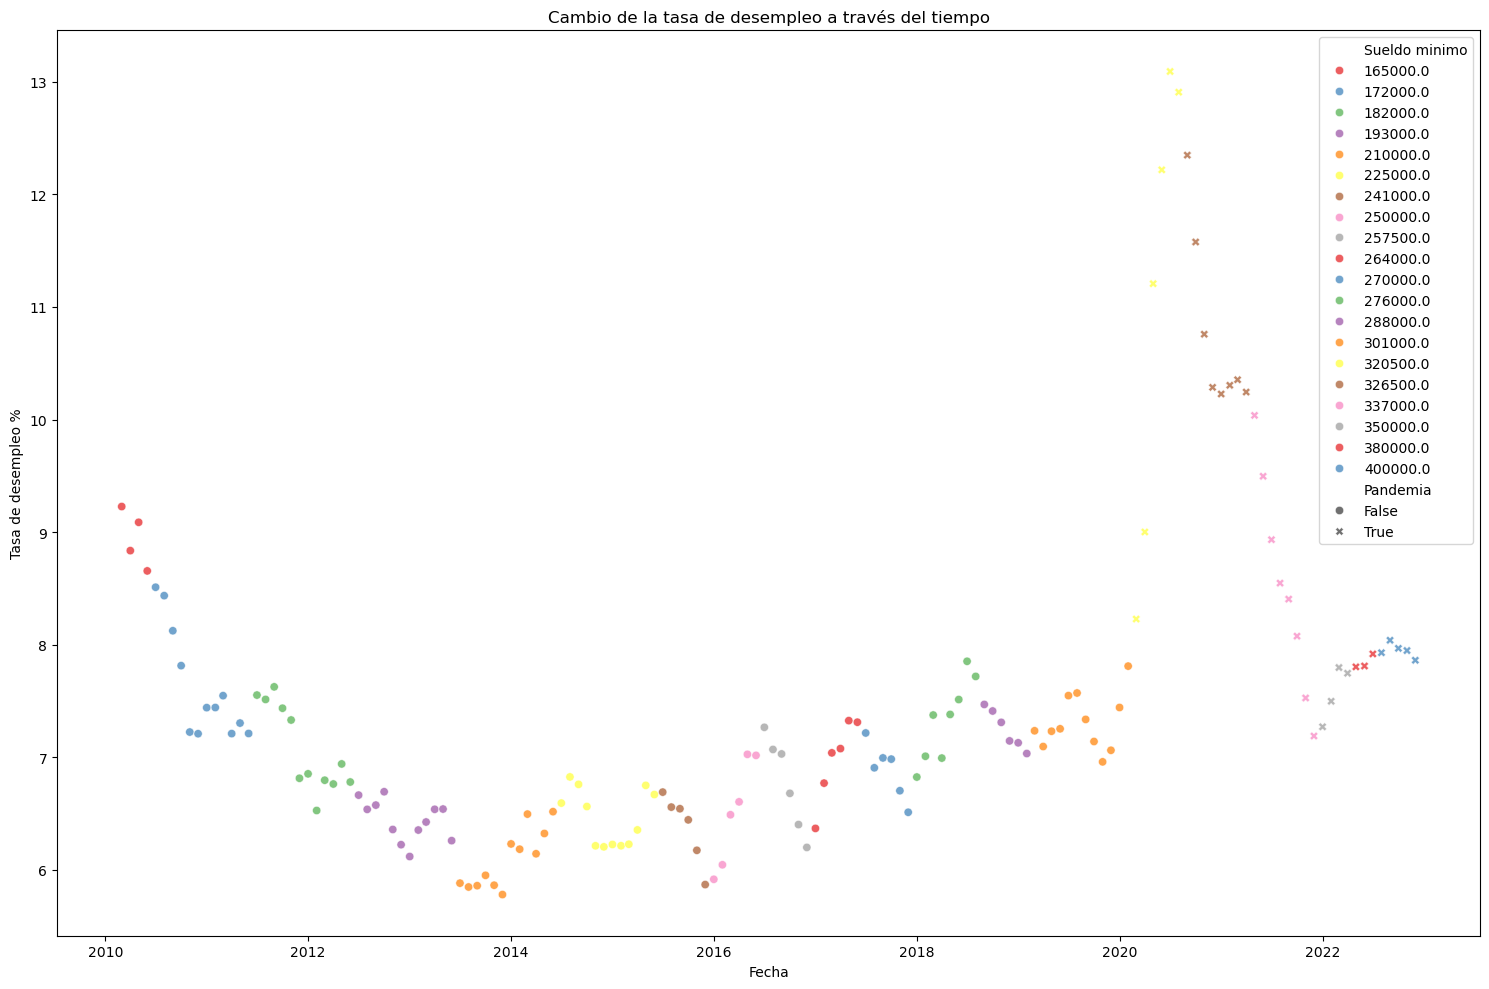

In [464]:
plt.figure(figsize=[15,10])
sns.scatterplot(data=df_minimo[df_minimo["Tramo etario"] == "Total"], x="Fecha", y="Tasa de desempleo",hue="Sueldo minimo",style="Pandemia", palette="Set1",alpha=0.7)
plt.title("Cambio de la tasa de desempleo a través del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Tasa de desempleo %")
plt.tight_layout()
plt.show()


El gráfico muestra como varia la tasa de desempleo con el paso del tiempo, coloreando cada sueldo mínimo y marcando el tiempo de pandemia. En el gráfico se ve que entre 2010 hasta 2014 con cada cambio de sueldo mínimo el desempleo disminuye. Entre 2014 y 2020 se ve que el desempleo aumentaba y disminuia de manera alternada con cada cambio de sueldo minimo, pero aumentando de a poco la tasa promedio. En 2020 se ve que hubo un gran aumento en la tasa desempleo, y aunque tambien cambio el sueldo minimo, el aumento se debio principalmente a la pandemia mundial. Dentro de la pandemia entre 2021 y 2022 hubo 2 cambios del sueldo minimo a los que le siguieron una baja en la tasa de desempleo.

In [466]:
df_etario.describe()

,Año,Mes,Tasa de empleo,Tasa de desempleo,ipc,Dólar observado,PIB per capita,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo,Razón sueldo minimo/ipc,Fecha
count,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924
mean,2016.077922,6.564935,55.614153,7.493424,71.873506,639.642597,14600.362117,397.644610,806.366115,2.035758,3513.486429,2016-07-16 11:59:59.999999744
min,2010.000000,1.000000,14.695963,1.406802,57.820000,462.940000,12632.870473,307.450000,362.000000,0.950000,2830.190000,2010-03-01 00:00:00
25%,2013.000000,4.000000,29.617484,3.843808,62.980000,517.170000,13649.852046,370.310000,688.815000,1.697500,3111.400000,2013-05-01 00:00:00
50%,2016.000000,7.000000,66.110112,5.508270,72.090000,651.275000,14529.676721,398.855000,838.435000,2.140000,3555.650000,2016-07-16 12:00:00
75%,2019.000000,10.000000,74.511534,9.112200,77.960000,718.440000,15451.131958,425.020000,958.552500,2.430000,3892.910000,2019-10-01 00:00:00
max,2022.000000,12.000000,79.445798,29.852019,97.210000,955.890000,16216.570647,473.140000,1211.250000,3.040000,4224.310000,2022-12-01 00:00:00
std,3.704466,3.428120,22.606263,5.290849,9.502516,124.088697,1039.273933,35.397393,204.572776,0.514582,413.291805,NaN


La tabla mostrada corresponde a un resumen estadístico de las variables numéricas del DataFrame df_etario, que contiene 924 observaciones. Se incluyen estadísticas como media, desviación estándar, mínimo, percentiles y máximo para variables como "Tasa de empleo", "Tasa de desempleo", "ipc", "Dólar observado", "PIB per capita", y distintos indicadores salariales. La "Tasa de desempleo" tiene un promedio de 7.49% y un máximo de casi 30%, lo que refleja una alta variabilidad. El "Dólar observado" muestra una media de 639.6 y una desviación importante, con valores que van desde 462.94 hasta 955.89, evidenciando alta volatilidad. El "PIB per capita" también presenta cierta variabilidad con un promedio cercano a los 14,600 USD. El "Sueldo mínimo USD" varía entre 307.45 y 473.14, mientras que el "Sueldo nominal USD" va de 362 a más de 1,200 USD. La "Razón sueldo nominal/mínimo" tiene un valor medio de 2.04, lo que implica que en promedio el sueldo nominal duplica el mínimo, pero con casos donde la relación es apenas cercana a 1 y otros que superan el triple. Estos indicadores proveen una base sólida para análisis exploratorios y modelos predictivos. Además, permiten estudiar la evolución del mercado laboral y su relación con condiciones económicas clave entre 2010 y 2022.

## Analizar la correlación del desempleo con las distintas variables

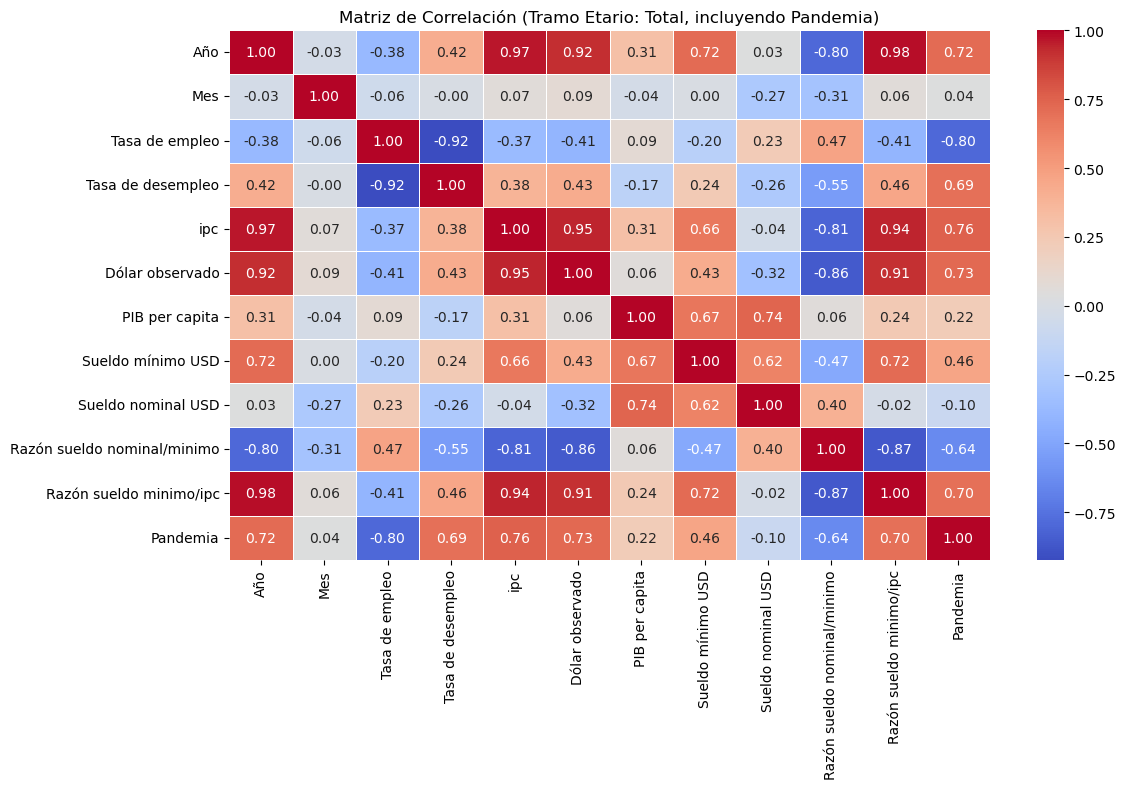


Suma de correlaciones absolutas (orden ascendente):
Mes                            1.958562
PIB per capita                 3.905070
Sueldo nominal USD             4.038475
Tasa de empleo                 5.318720
Tasa de desempleo              5.524579
Sueldo mínimo USD              6.187283
Pandemia                       6.851063
Dólar observado                7.084152
Razón sueldo nominal/minimo    7.221339
ipc                            7.259896
Año                            7.266856
Razón sueldo minimo/ipc        7.313977
dtype: float64

Mayores correlaciones absolutas con la tasa de desempleo:
Tasa de desempleo              1.000000
Tasa de empleo                 0.921783
Pandemia                       0.692732
Razón sueldo nominal/minimo    0.547996
Razón sueldo minimo/ipc        0.459390
Dólar observado                0.426324
Año                            0.421701
ipc                            0.384080
Sueldo nominal USD             0.259718
Sueldo mínimo USD              0.

In [469]:
# Filtrar solo las filas donde el tramo etario sea "Total"
df_total = df_encoded[df_encoded["Tramo etario_Total"] == 1].copy()

# Asegurar que la columna Pandemia esté presente y sea numérica (True -> 1, False -> 0)
if "Pandemia" in df_total.columns:
    df_total["Pandemia"] = df_total["Pandemia"].astype(int)

# Seleccionar solo columnas numéricas
df_total_numeric = df_total.select_dtypes(include="number")

# Calcular la matriz de correlación
correlation_matrix = df_total_numeric.corr()

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación (Tramo Etario: Total, incluyendo Pandemia)")
plt.tight_layout()
plt.show()

# Calcular y mostrar suma de correlaciones absolutas (orden ascendente)
suma_corr_abs = correlation_matrix.abs().sum().sort_values()
print("\nSuma de correlaciones absolutas (orden ascendente):")
print(suma_corr_abs)
print("\nMayores correlaciones absolutas con la tasa de desempleo:")
print(correlation_matrix["Tasa de desempleo"].abs().sort_values(ascending=False))

Esta sección del código tiene como propósito analizar las relaciones entre las variables numéricas del conjunto de datos filtrado, específicamente para el tramo etario “Total”. Para lograrlo, primero se seleccionan únicamente las filas donde la columna Tramo etario_Total tenga valor 1, es decir, aquellas que representan el promedio general sin segmentación por edad. Esta decisión permite simplificar el análisis y enfocarse en el comportamiento agregado de las variables laborales y económicas a lo largo del tiempo, sin la variabilidad introducida por las diferencias etarias.

La tasa de desempleo muestra una correlación moderadamente positiva con variables como el año (0.42), el IPC (0.38), la razón sueldo mínimo/ipc (0.46) y el dólar observado (0.43), lo que indica que tiende a aumentar con el paso del tiempo, la inflación y la devaluación del peso. La pandemia presenta una fuerte correlación positiva (0.69), reflejando su impacto negativo en el empleo. En contraste, presenta una correlación moderadamente negativa con la razón sueldo nominal/mínimo (-0.55) y débilmente negativa con el sueldo nominal USD (-0.26), sugiriendo que mayores ingresos reales están asociados a menores niveles de desempleo. El PIB per cápita tiene una relación débilmente negativa (-0.17), mientras que el sueldo mínimo en USD tiene una débil relación positiva (0.24), posiblemente reflejando efectos mixtos en el mercado laboral. La variable mes muestra una correlación nula, lo que indica ausencia de estacionalidad marcada. En conjunto, el desempleo se ve más influido por condiciones macroeconómicas e impactos extraordinarios que por variaciones de corto plazo.

## Pairplot variables relacionadas con el desempleo

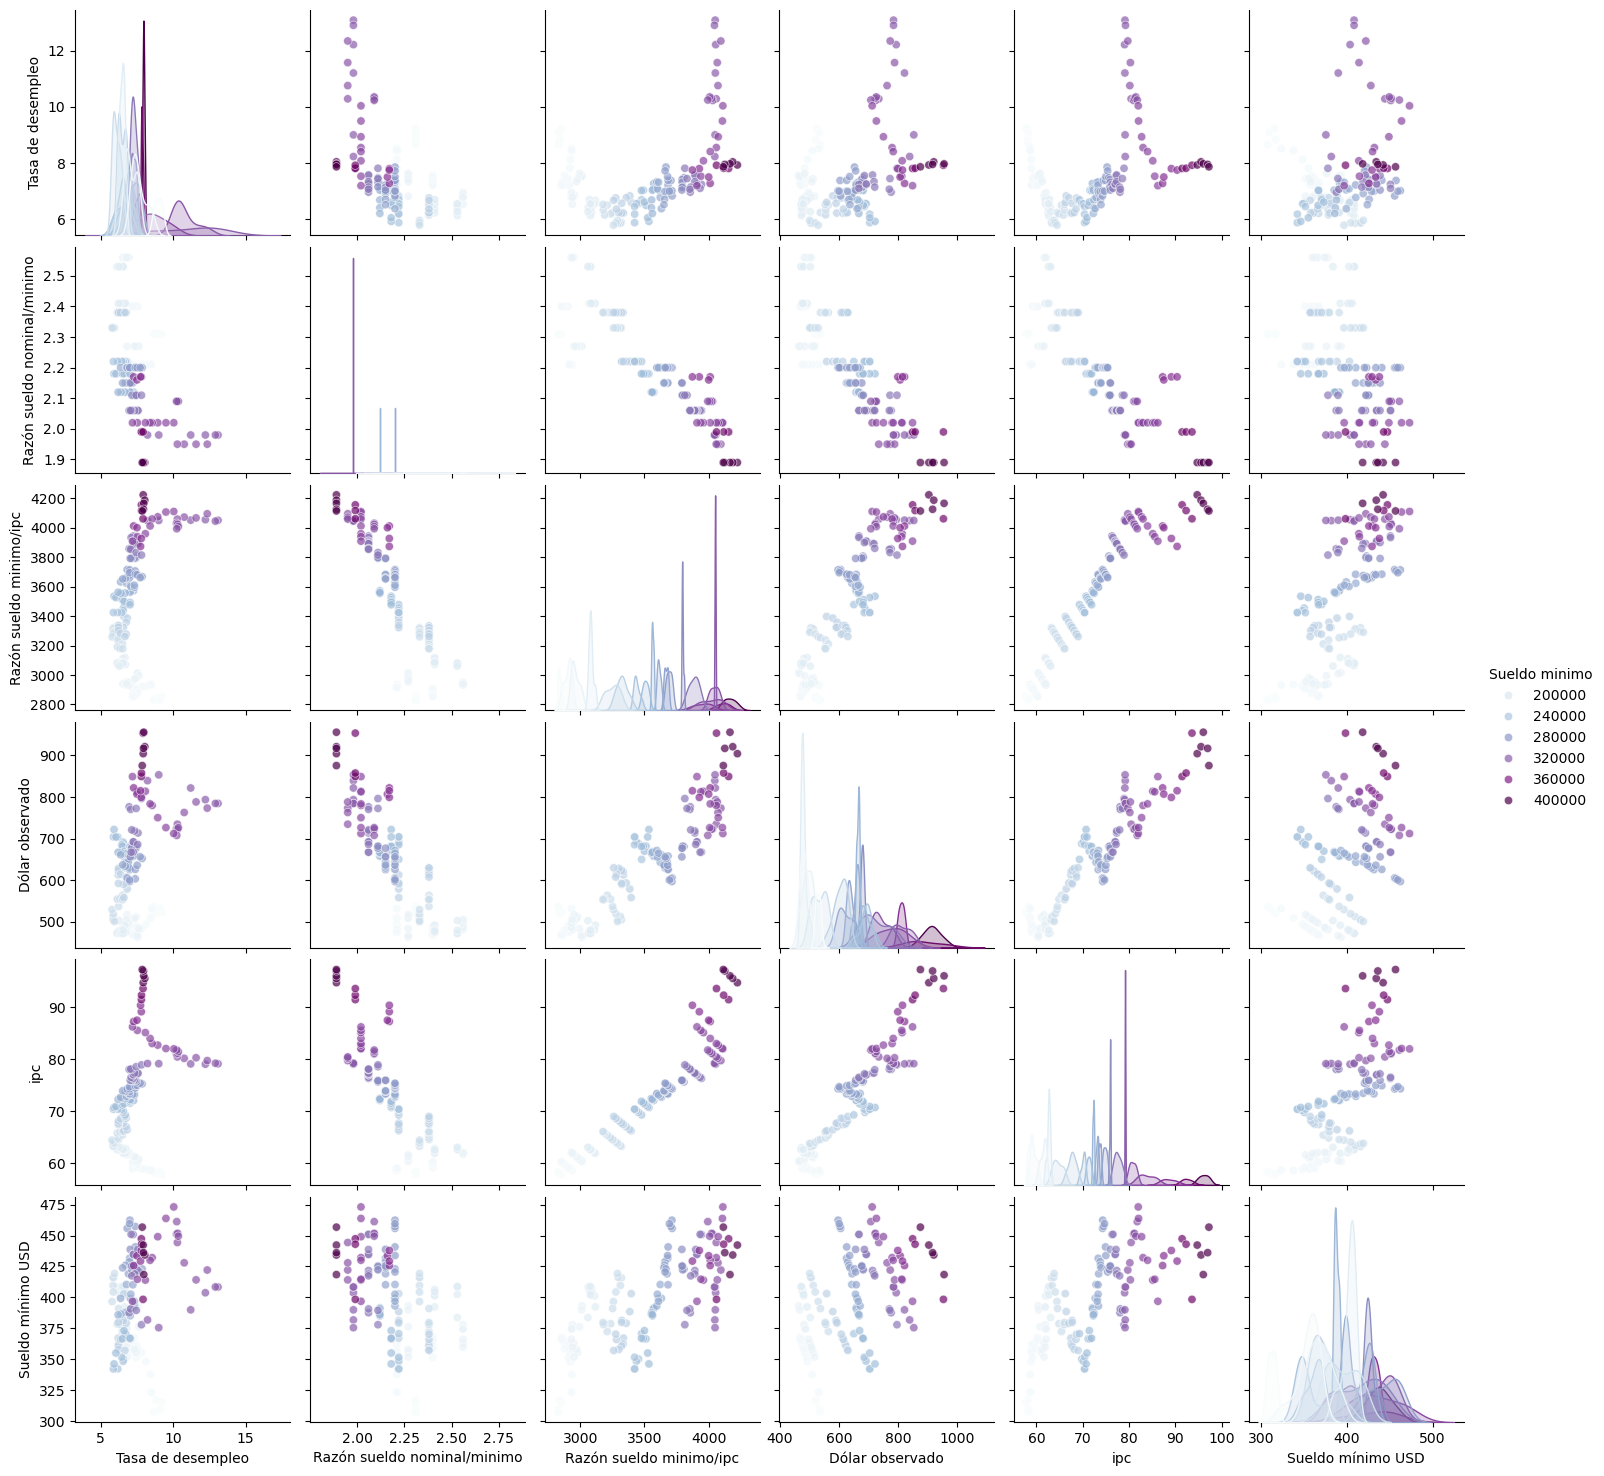

In [473]:
df_min_total=df_minimo[df_minimo["Tramo etario"] == "Total"]
select=["Tasa de desempleo","Razón sueldo nominal/minimo","Razón sueldo minimo/ipc","Dólar observado","ipc","Sueldo mínimo USD","Sueldo minimo"]
sns.pairplot(df_min_total[select],hue='Sueldo minimo', palette="BuPu", plot_kws=dict(alpha=0.7))

A simple vista se percibe que el sueldo minimo esta correlacionado con una mayor tasa de desempleo, aumento del dolar y un mayor ipc, pero estos datos estan ignorando eventos como lo fue la pandemia asi que hay que hacer mas analisis.

In [475]:
df_total.describe()

,Año,Mes,Tasa de empleo,Tasa de desempleo,ipc,Dólar observado,PIB per capita,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo,Razón sueldo minimo/ipc,Fecha,Pandemia
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154,154.000000
mean,2016.077922,6.564935,56.440262,7.441152,71.873506,639.642597,14600.362117,397.644610,875.318377,2.208117,3513.486429,2016-07-16 12:00:00,0.220779
min,2010.000000,1.000000,45.033236,5.781732,57.820000,462.940000,12632.870473,307.450000,709.580000,1.890000,2830.190000,2010-03-01 00:00:00,0.000000
25%,2013.000000,4.000000,55.483014,6.547625,63.002500,517.690000,13649.852046,370.405000,817.355000,2.090000,3113.160000,2013-05-08 18:00:00,0.000000
50%,2016.000000,7.000000,57.635102,7.135326,72.090000,651.275000,14529.676721,398.855000,878.845000,2.200000,3555.650000,2016-07-16 12:00:00,0.000000
75%,2019.000000,9.750000,58.155192,7.785272,77.802500,717.255000,15451.131958,424.745000,929.455000,2.330000,3892.785000,2019-09-23 12:00:00,0.000000
max,2022.000000,12.000000,59.103645,13.091216,97.210000,955.890000,16216.570647,473.140000,1034.430000,2.560000,4224.310000,2022-12-01 00:00:00,1.000000
std,3.714540,3.437443,2.875437,1.395954,9.528359,124.426170,1042.100356,35.493661,74.599494,0.167046,414.415799,NaN,0.416125


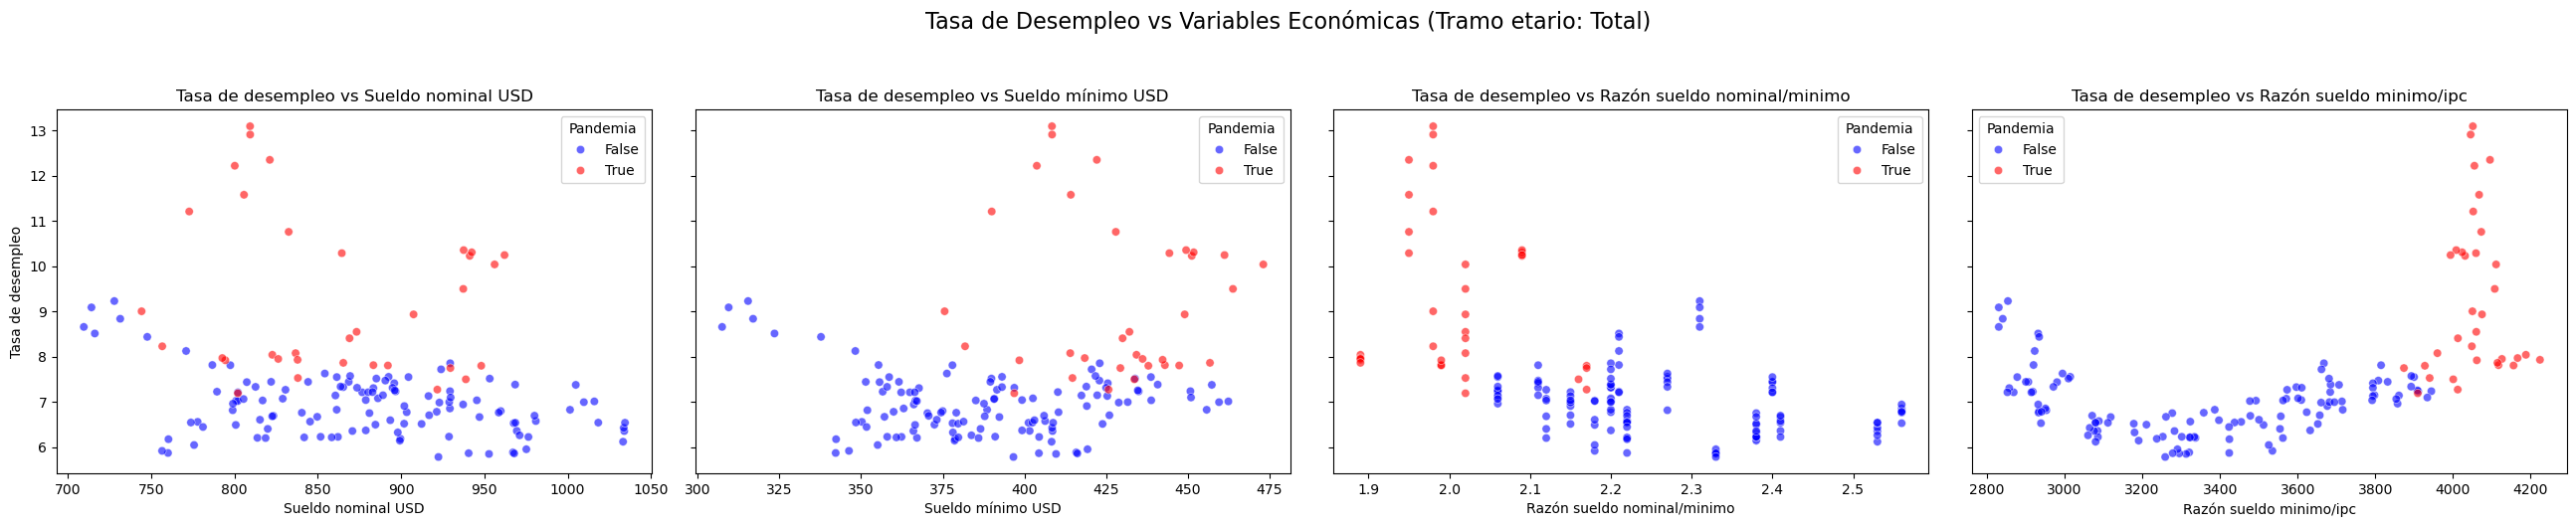

In [476]:
# Filtrar solo las filas donde el tramo etario sea "Total"
df_total = df_encoded[df_encoded["Tramo etario_Total"] == 1].copy()

# Asegurarse que la columna Pandemia esté en formato booleano
df_total["Pandemia"] = df_total["Pandemia"].astype(bool)

# Columnas de interés para este gráfico (agregamos la nueva variable)
x_vars = [
    "Sueldo nominal USD",
    "Sueldo mínimo USD",
    "Razón sueldo nominal/minimo",
    "Razón sueldo minimo/ipc"
]
x_vars_2 = [
    "PIB per capita",
    "Dólar observado",
    "ipc"
]
y_var = "Tasa de desempleo"

# Eliminar filas con valores faltantes
df_plot = df_total[[y_var, "Pandemia"] + x_vars].dropna()

# Crear una fila de subplots
fig, axes = plt.subplots(1, len(x_vars), figsize=(26, 5), sharey=True)
# Generar scatterplots para cada variable explicativa
for i, var in enumerate(x_vars):
    sns.scatterplot(
        data=df_plot,
        x=var,
        y=y_var,
        hue="Pandemia",
        ax=axes[i],
        alpha=0.6,
        palette={True: "red", False: "blue"}
    )
    axes[i].set_title(f"{y_var} vs {var}")
    axes[i].legend().set_title("Pandemia")

# Ajustar presentación
plt.suptitle("Tasa de Desempleo vs Variables Económicas (Tramo etario: Total)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()



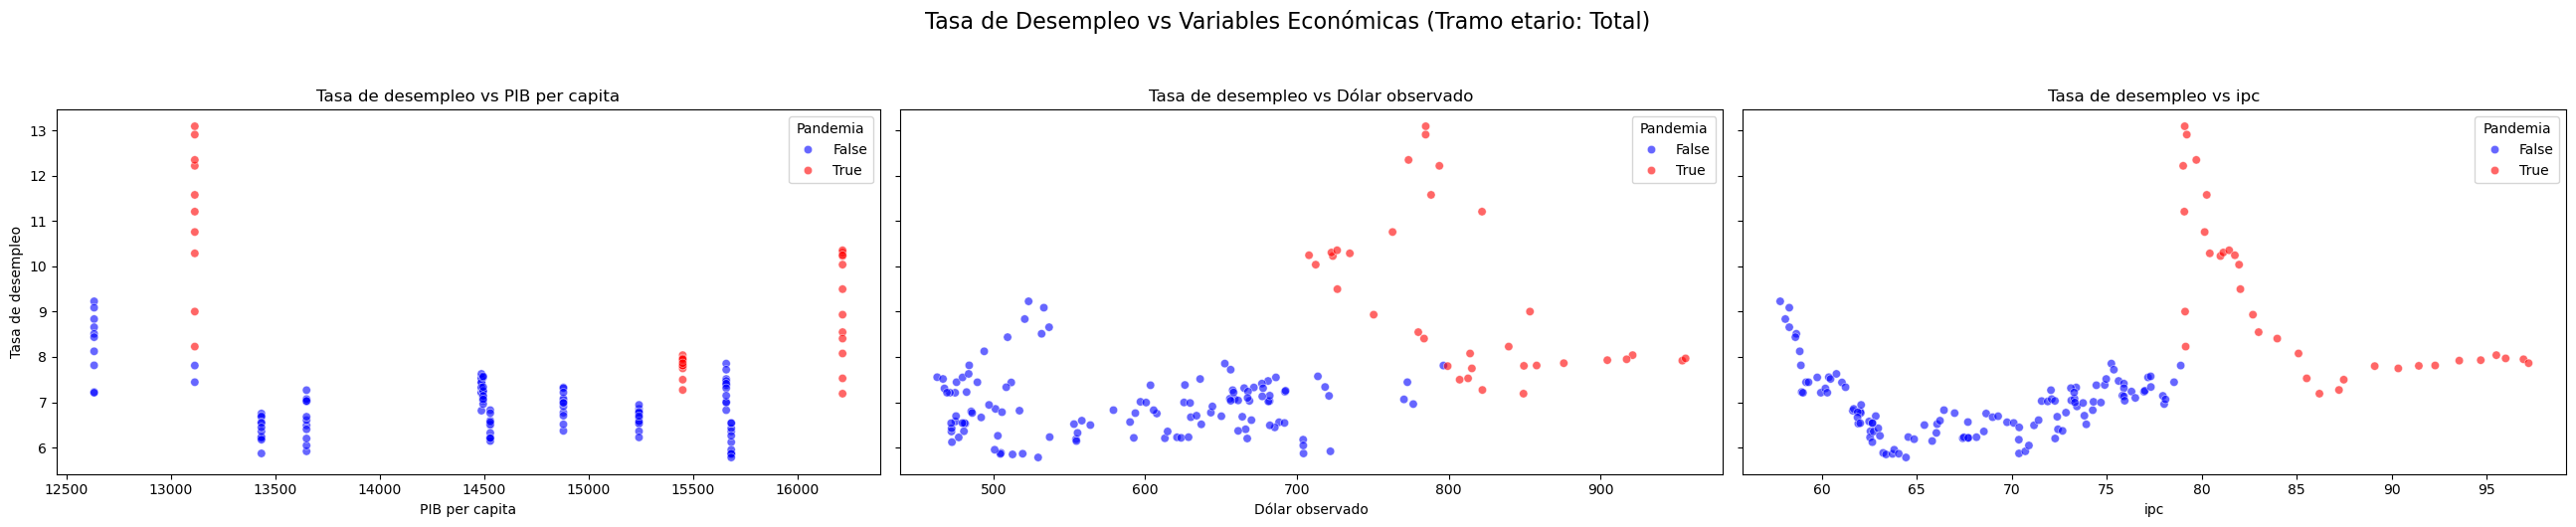

In [477]:
# Eliminar filas con valores faltantes
df_plot = df_total[[y_var, "Pandemia"] + x_vars_2].dropna()
# Crear una fila de subplots
fig, axes = plt.subplots(1, len(x_vars_2), figsize=(26, 5), sharey=True)
#fig, axes = plt.subplots(1, 4, figsize=(26, 4), sharey=True)
# Generar scatterplots para cada variable explicativa
for i, var in enumerate(x_vars_2):
    sns.scatterplot(
        data=df_plot,
        x=var,
        y=y_var,
        hue="Pandemia",
        ax=axes[i],
        alpha=0.6,
        palette={True: "red", False: "blue"}
    )
    axes[i].set_title(f"{y_var} vs {var}")
    axes[i].legend().set_title("Pandemia")

# Ajustar presentación
plt.suptitle("Tasa de Desempleo vs Variables Económicas (Tramo etario: Total)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Este bloque de código se centra en analizar gráficamente la relación entre la tasa de desempleo y distintas variables económicas para el tramo etario “Total”. Primero, se asegura que la columna “Pandemia” esté en formato booleano, para poder diferenciar visualmente los períodos pandémicos con un color distinto. A continuación, se definen las variables explicativas de interés, como el IPC, el PIB per cápita y el valor del dólar, y se eliminan las filas con datos faltantes. Se genera una fila de gráficos de dispersión (scatterplots), donde cada uno muestra la relación entre una variable económica y la tasa de desempleo. Los puntos se colorean según si pertenecen o no al período pandémico, facilitando la identificación visual de patrones específicos de ese contexto. Se puede apreciar que la pandemia es un evento que esta vinculado a los datos que tienen la mayor tasa de desempleo.

El gráfico muestra que durante la pandemia (puntos rojos) la tasa de desempleo fue consistentemente más alta, independientemente del valor de las variables económicas. No se observa una relación lineal clara entre el sueldo nominal o mínimo en USD y el desempleo, aunque fuera de la pandemia tienden a concentrarse en niveles más bajos. La razón sueldo nominal/mínimo muestra una leve relación inversa con el desempleo en condiciones normales, pero se rompe en pandemia. La razón sueldo mínimo/ipc muestra una especie de parabola con los valores más bajos en su parte central. El PIB per cápita elevado no garantiza baja desocupación durante crisis. El aumento del dólar observado coincide con mayores tasas de desempleo en pandemia, sugiriendo un posible vínculo con incertidumbre económica. El IPC muestra una relación no lineal, con desempleo alto tanto en niveles bajos como altos. En general, la pandemia altera fuertemente los patrones habituales entre estas variables. Esto resalta la sensibilidad del empleo a eventos macroeconómicos extremos.

C:\Users\fcluc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


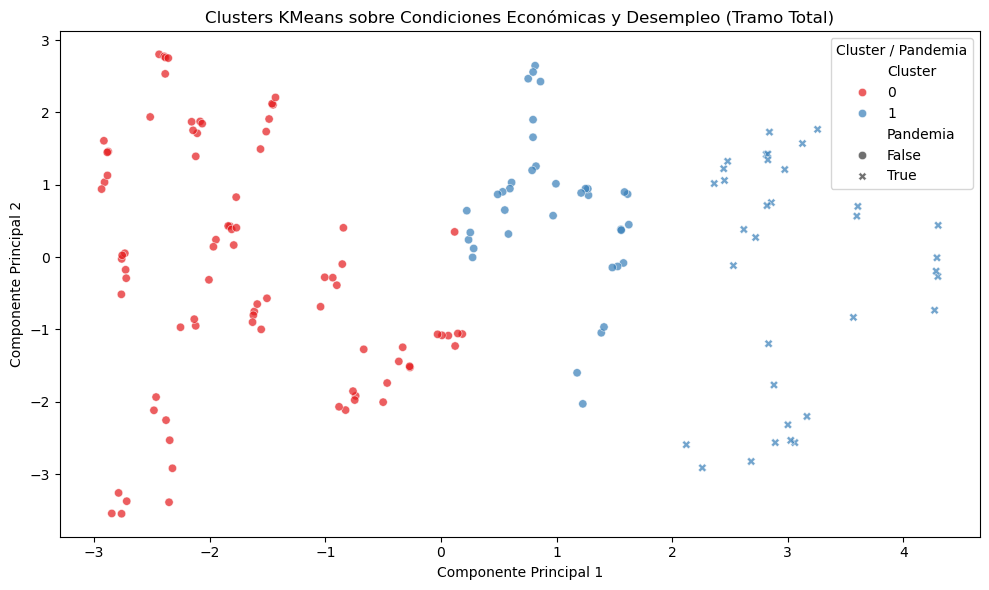

In [480]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Seleccionar variables relevantes para clustering
cluster_vars = [
    "Tasa de desempleo",
    "Sueldo nominal USD",
    "Sueldo mínimo USD",
    "Razón sueldo nominal/minimo",
    "Razón sueldo minimo/ipc",
    "PIB per capita",
    "Dólar observado",
    "ipc"
]

df_cluster = df_encoded[df_encoded["Tramo etario_Total"] == 1].copy()
df_cluster = df_cluster.dropna(subset=cluster_vars + ["Pandemia"])  # Eliminar filas con valores nulos

# 2. Estandarizar las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[cluster_vars])

# 3. Aplicar KMeans (e.g., 3 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
df_cluster["Cluster"] = kmeans.fit_predict(X_scaled)

# 4. Reducir a 2 dimensiones para graficar con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster["PC1"] = X_pca[:, 0]
df_cluster["PC2"] = X_pca[:, 1]

# 5. Graficar los clusters con color y estilo según Pandemia
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cluster,
    x="PC1",
    y="PC2",
    hue="Cluster",
    style="Pandemia",
    palette="Set1",
    alpha=0.7
)
plt.title("Clusters KMeans sobre Condiciones Económicas y Desempleo (Tramo Total)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster / Pandemia")
plt.tight_layout()
plt.show()


Este bloque de código implementa un análisis de clustering con KMeans para identificar patrones similares en las condiciones económicas y la tasa de desempleo, considerando únicamente el tramo etario "Total". Primero, se seleccionan variables económicas clave como el sueldo, el PIB y el dólar observado, y se eliminan las filas con datos faltantes. Luego, estas variables se estandarizan para garantizar que todas tengan igual peso en el análisis. Se aplica el algoritmo KMeans con tres clusters, permitiendo agrupar observaciones similares. Posteriormente, se utiliza PCA para reducir la dimensionalidad del conjunto de datos a dos componentes principales, facilitando la visualización. El resultado se grafica en un plano, coloreando los puntos según su cluster asignado y diferenciando por forma si pertenecen al período pandémico. Este enfoque permite visualizar cómo se agrupan distintos contextos económicos y evaluar si la pandemia generó agrupaciones distintas. Se puede apreciar que los datos relacionados con la pandemia se agrupan en el cluster 1.

## Analisis sin pandemia

In [483]:
df_encoded.dtypes

Año                                     int32
Mes                                     int64
Tasa de empleo                        float64
Tasa de desempleo                     float64
ipc                                   float64
Dólar observado                       float64
PIB per capita                        float64
Sueldo mínimo USD                     float64
Sueldo nominal USD                    float64
Razón sueldo nominal/minimo           float64
Razón sueldo minimo/ipc               float64
Fecha                          datetime64[ns]
Pandemia                                 bool
Cambio de sueldo                         bool
Tramo etario_15-24 años                  bool
Tramo etario_25-34 años                  bool
Tramo etario_35-44 años                  bool
Tramo etario_45-54 años                  bool
Tramo etario_55-64 años                  bool
Tramo etario_65 años y más               bool
Tramo etario_Total                       bool
dtype: object

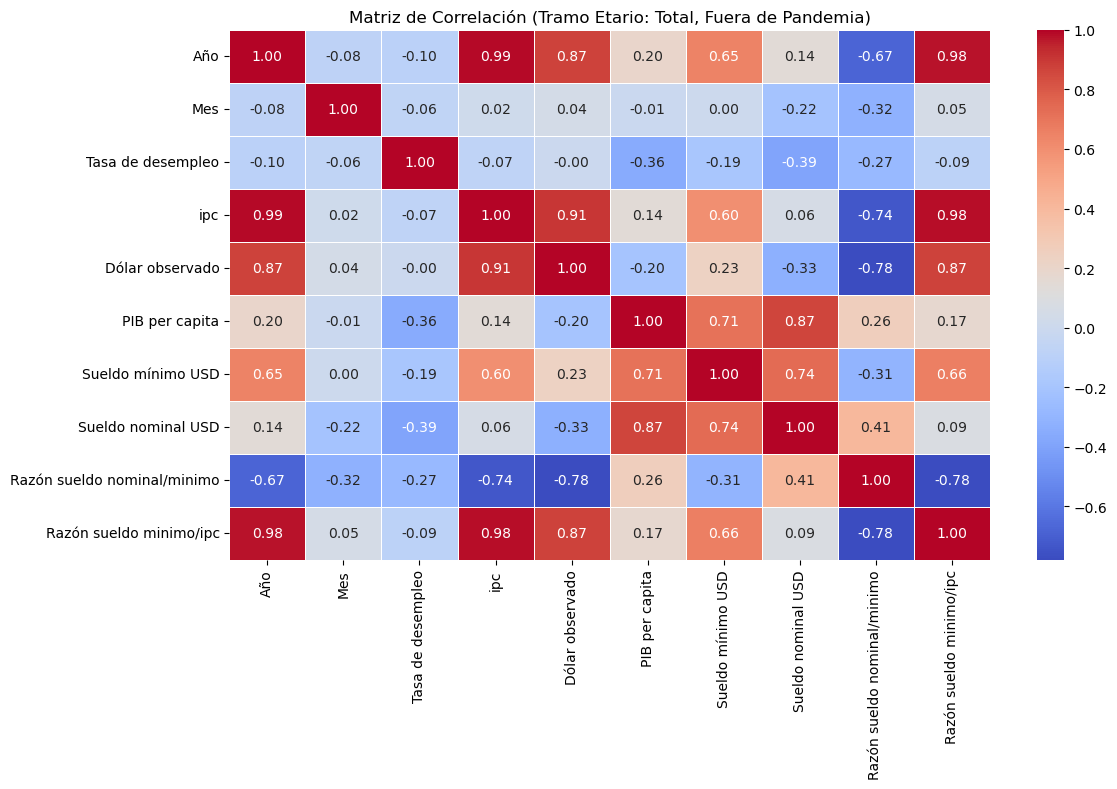


Suma de correlaciones absolutas (orden ascendente):
Mes                            1.806160
Tasa de desempleo              2.538929
PIB per capita                 3.925675
Sueldo nominal USD             4.235157
Sueldo mínimo USD              5.103925
Dólar observado                5.239985
ipc                            5.503825
Razón sueldo nominal/minimo    5.537842
Razón sueldo minimo/ipc        5.666905
Año                            5.687247
dtype: float64

Mayores correlaciones absolutas con la tasa de desempleo:
Tasa de desempleo              1.000000
Sueldo nominal USD             0.393789
PIB per capita                 0.358354
Razón sueldo nominal/minimo    0.272663
Sueldo mínimo USD              0.193847
Año                            0.096129
Razón sueldo minimo/ipc        0.086345
ipc                            0.070878
Mes                            0.063397
Dólar observado                0.003526
Name: Tasa de desempleo, dtype: float64


In [484]:
# Filtrar para analizar sin el momento anomalo de la pandemia
dropped=["Tasa de empleo","Fecha","Pandemia","Cambio de sueldo","Tramo etario_15-24 años","Tramo etario_25-34 años","Tramo etario_35-44 años","Tramo etario_45-54 años","Tramo etario_55-64 años","Tramo etario_65 años y más","Tramo etario_Total"]
df_total_s = df_total[df_total["Pandemia"] == False].drop(columns=dropped).copy()

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(df_total_s.select_dtypes(include="number").corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación (Tramo Etario: Total, Fuera de Pandemia)")
plt.tight_layout()
plt.show()

# Calcular y mostrar suma de correlaciones absolutas (orden ascendente)
suma_corr_abs = df_total_s.select_dtypes(include="number").corr().abs().sum().sort_values()
print("\nSuma de correlaciones absolutas (orden ascendente):")
print(suma_corr_abs)
print("\nMayores correlaciones absolutas con la tasa de desempleo:")
print(df_total_s.select_dtypes(include="number").corr()["Tasa de desempleo"].abs().sort_values(ascending=False))

## Regresion lineal para el desempleo vs las variables

La pendiente de Tasa de desempleo vs Sueldo nominal USD es:-0.003444538717890872
El intercepto de Tasa de desempleo vs Sueldo nominal USD es:9.957133837176007


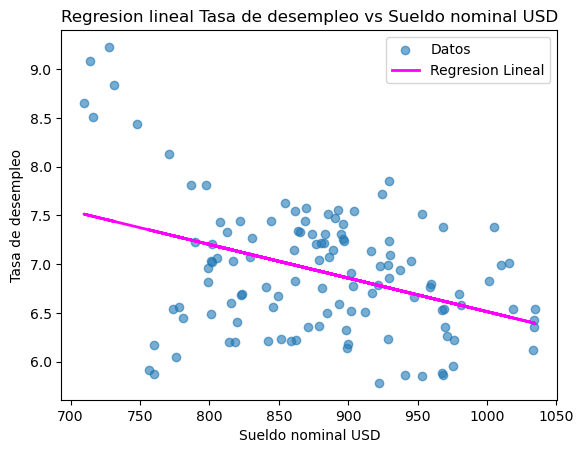

In [486]:
import numpy as np

def regressionlineal(x="Sueldo nominal USD",y="Tasa de desempleo"):
        X_f=df_total_s[[x]]
        y_f=df_total_s[[y]]
        lr = LinearRegression()
        lr.fit(X_f,y_f)
        pendiente =lr.coef_[0][0]
        intercept = lr.intercept_[0]
        y1 = pendiente*X_f + intercept
        print(f"La pendiente de {y} vs {x} es:{pendiente}")
        print(f"El intercepto de {y} vs {x} es:{intercept}")
        
        plt.scatter(X_f, y_f, alpha=0.6, label="Datos")
        plt.title(f"Regresion lineal {y} vs {x}")
        plt.xlabel(f'{x}')
        plt.ylabel(f'{y}')
        plt.plot(X_f, y1, color='magenta', lw=2, linestyle='-', label="Regresion Lineal")
        plt.legend()
regressionlineal()

La pendiente de Tasa de desempleo vs Sueldo mínimo USD es:-0.0039224686316666054
El intercepto de Tasa de desempleo vs Sueldo mínimo USD es:8.453575125643919


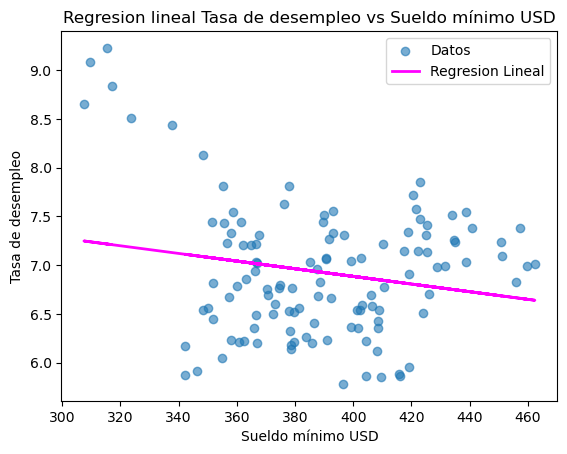

In [487]:
regressionlineal("Sueldo mínimo USD")

La pendiente de Tasa de desempleo vs Razón sueldo nominal/minimo es:-1.3204827068242315
El intercepto de Tasa de desempleo vs Razón sueldo nominal/minimo es:9.918542327646612


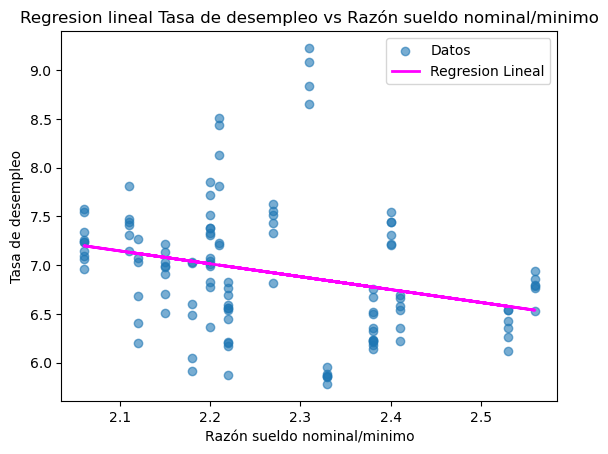

In [488]:
regressionlineal("Razón sueldo nominal/minimo")

La pendiente de Tasa de desempleo vs Razón sueldo minimo/ipc es:-0.0001738704468573905
El intercepto de Tasa de desempleo vs Razón sueldo minimo/ipc es:7.512399311458855


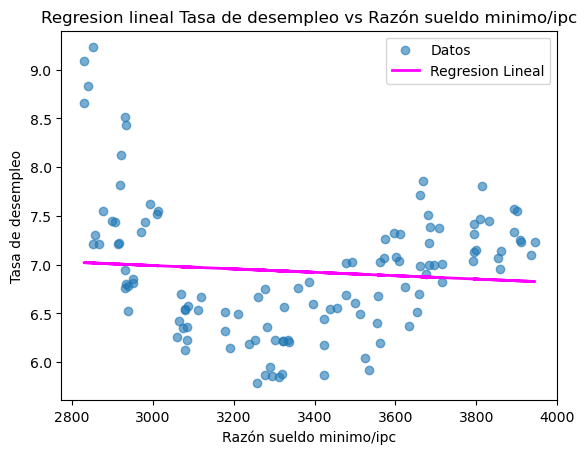

In [489]:
regressionlineal("Razón sueldo minimo/ipc")

La pendiente de Tasa de desempleo vs PIB per capita es:-0.0002610083791890244
El intercepto de Tasa de desempleo vs PIB per capita es:10.706827483465483


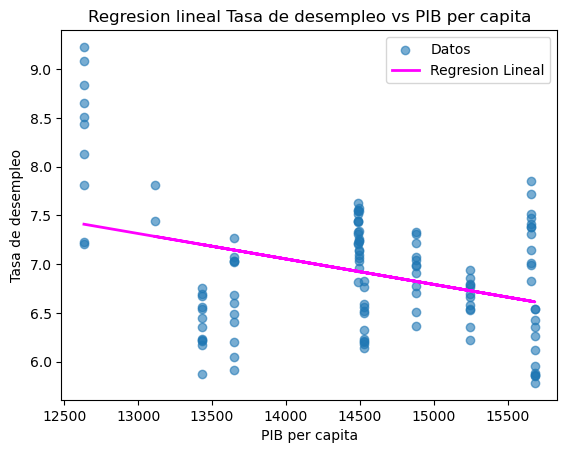

In [490]:
regressionlineal("PIB per capita")

La pendiente de Tasa de desempleo vs Dólar observado es:-2.6555534341922555e-05
El intercepto de Tasa de desempleo vs Dólar observado es:6.943796964173604


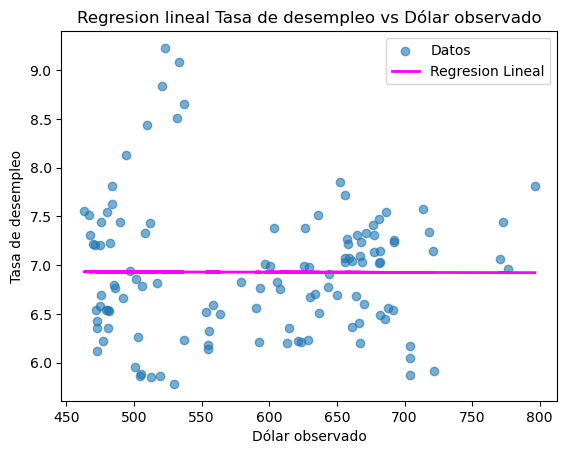

In [491]:
regressionlineal("Dólar observado")

La pendiente de Tasa de desempleo vs ipc es:-0.007608587083198098
El intercepto de Tasa de desempleo vs ipc es:7.445824976402073


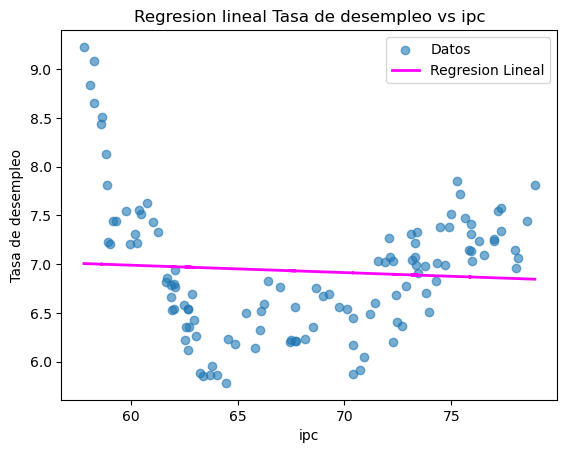

In [492]:
regressionlineal("ipc")

fff

# Análisis de Regresión Ridge y Kernel Ridge para Predecir la Tasa de Desempleo

In [495]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def analizar_feature(df, feature):
    X = df[[feature]].values
    X_scaled = StandardScaler().fit_transform(X)
    y = df['Tasa de desempleo']
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    ridge = Ridge()
    krr = KernelRidge(kernel='rbf')
    ridge.fit(X_train, y_train)
    krr.fit(X_train, y_train)

    X_plot = np.linspace(X_scaled.min(), X_scaled.max(), 200).reshape(-1, 1)
    ridge_pred = ridge.predict(X_plot)
    krr_pred = krr.predict(X_plot)

    print(f"[{feature}] Ridge MSE - Train: {mean_squared_error(y_train, ridge.predict(X_train)):.4f}")
    print(f"[{feature}] KRR MSE - Train: {mean_squared_error(y_train, krr.predict(X_train)):.4f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(X_scaled, y, alpha=0.5, label='Datos reales')
    plt.plot(X_plot, ridge_pred, color='red', label='Ridge (Rojo)')
    plt.plot(X_plot, krr_pred, color='yellow', label='Kernel Ridge (Amarillo)')
    plt.title(f'Tasa de Desempleo vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Tasa de Desempleo')
    plt.legend()
    plt.grid(True)
    plt.show()


[Sueldo mínimo USD] Ridge MSE - Train: 0.4025
[Sueldo mínimo USD] KRR MSE - Train: 0.4444


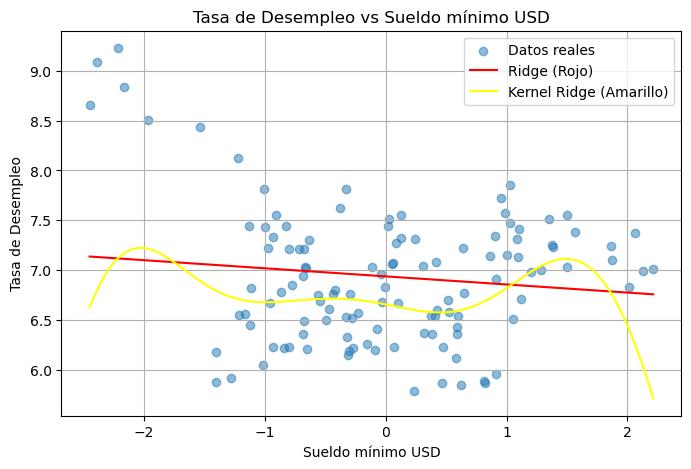

In [496]:
analizar_feature(df_total_s, 'Sueldo mínimo USD')

[Sueldo nominal USD] Ridge MSE - Train: 0.3553
[Sueldo nominal USD] KRR MSE - Train: 0.4418


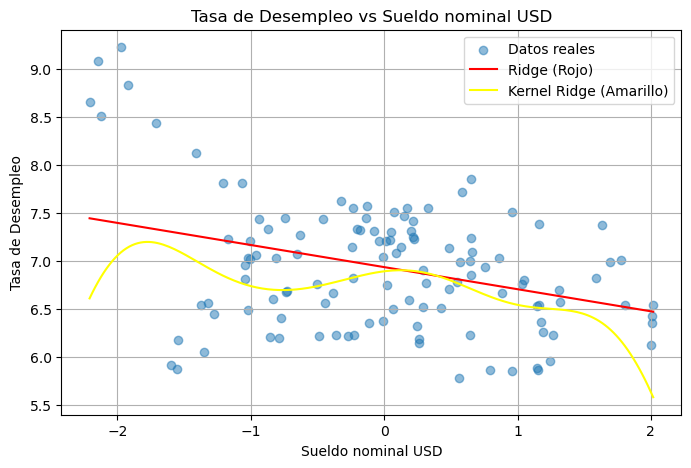

In [497]:
analizar_feature(df_total_s, 'Sueldo nominal USD')

[PIB per capita] Ridge MSE - Train: 0.3711
[PIB per capita] KRR MSE - Train: 0.3242


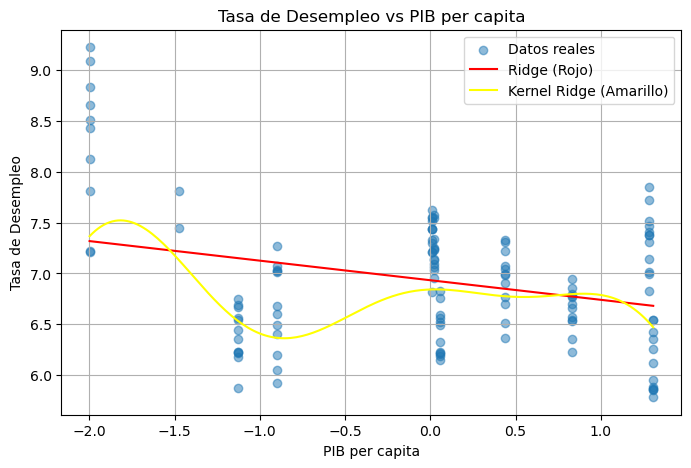

In [498]:
analizar_feature(df_total_s, 'PIB per capita')

[Dólar observado] Ridge MSE - Train: 0.4086
[Dólar observado] KRR MSE - Train: 0.5015


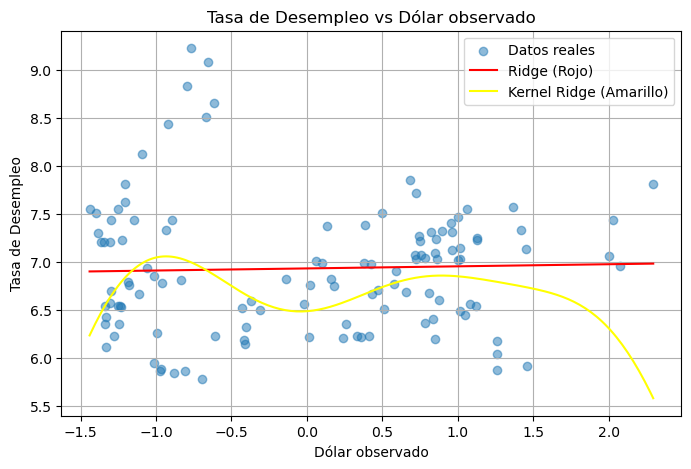

In [499]:
analizar_feature(df_total_s, 'Dólar observado')

[ipc] Ridge MSE - Train: 0.4090
[ipc] KRR MSE - Train: 0.2230


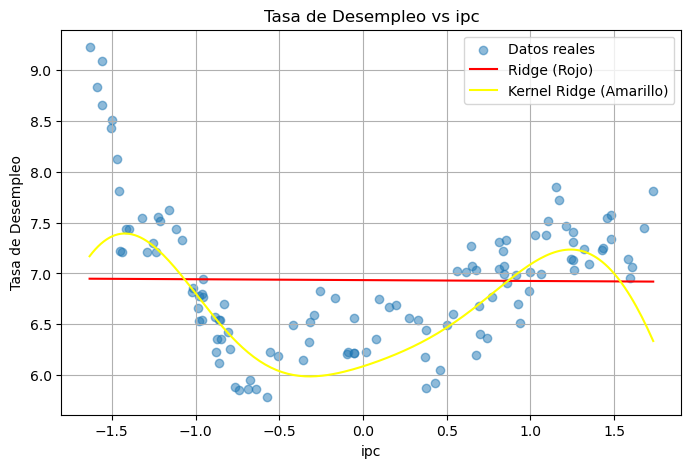

In [500]:
analizar_feature(df_total_s, 'ipc')

[Razón sueldo nominal/minimo] Ridge MSE - Train: 0.3681
[Razón sueldo nominal/minimo] KRR MSE - Train: 0.4298


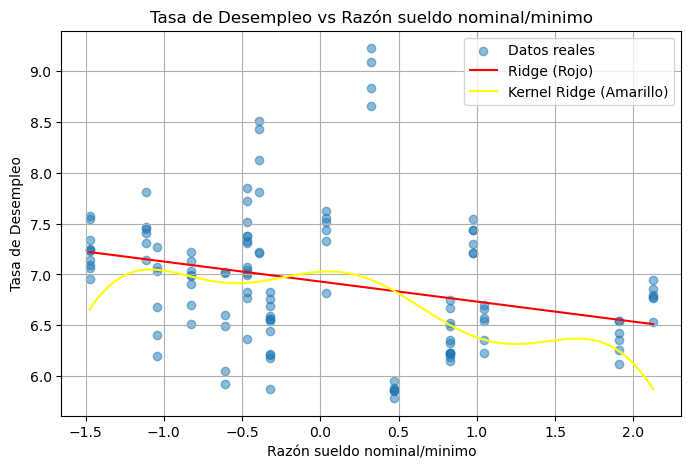

In [501]:
analizar_feature(df_total_s, 'Razón sueldo nominal/minimo')

[Razón sueldo minimo/ipc] Ridge MSE - Train: 0.4089
[Razón sueldo minimo/ipc] KRR MSE - Train: 0.2710


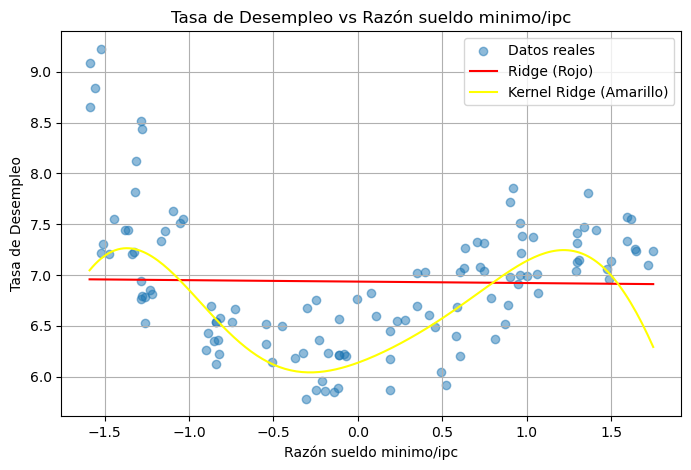

In [502]:
analizar_feature(df_total_s, 'Razón sueldo minimo/ipc')

Se evalúa el desempeño de modelos Ridge y Kernel Ridge (con kernel RBF) utilizando distintas variables económicas como predictores individuales de la tasa de desempleo. Se reportan los errores cuadráticos medios (MSE) de entrenamiento y testing, junto con gráficos de dispersión y curvas de predicción.

# Análisis de Regresión con todas las varibles para predecir Tasa de desempleo

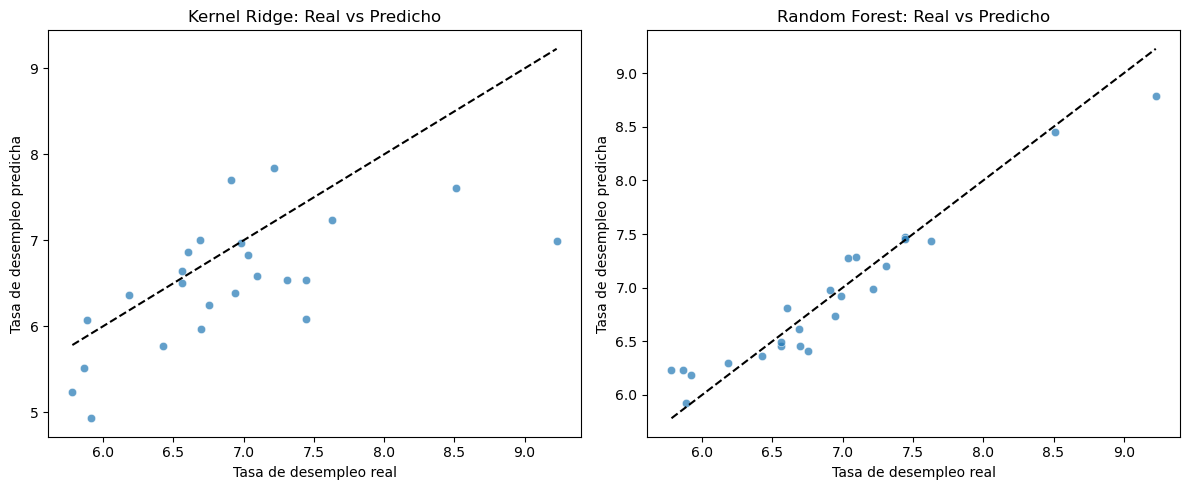

Kernel Ridge - MSE: 0.5709
Random Forest - MSE: 0.0464


In [505]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
# 1. Definir variables X e y
#df_encoded_s=df_encoded[df_encoded["Pandemia"] == False].drop(columns=["Fecha"])
df_model = df_total_s.copy()
df_model = df_model.dropna(subset=["Tasa de desempleo"])  # Eliminar nulos en y

X = df_model.drop(columns=["Tasa de desempleo"])  # Todas menos la target
y = df_model["Tasa de desempleo"]

# 2. Separar en entrenamiento y test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Estandarizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Modelos
def train_kernel_ridge(X_train, y_train, alpha=1.0, kernel='rbf'):
    model = KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train, y_train)
    return model

def train_random_forest(X_train, y_train, n_estimators=100, max_depth=None):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    return model

# 5. Entrenar modelos
kr_model = train_kernel_ridge(X_train_scaled, y_train)
rf_model = train_random_forest(X_train_scaled, y_train)

# 6. Predicciones
y_pred_kr = kr_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)

# 7. Gráficos de dispersión real vs predicho
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Kernel Ridge
sns.scatterplot(x=y_test, y=y_pred_kr, ax=axes[0], alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[0].set_title("Kernel Ridge: Real vs Predicho")
axes[0].set_xlabel("Tasa de desempleo real")
axes[0].set_ylabel("Tasa de desempleo predicha")

# Random Forest
sns.scatterplot(x=y_test, y=y_pred_rf, ax=axes[1], alpha=0.7)
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[1].set_title("Random Forest: Real vs Predicho")
axes[1].set_xlabel("Tasa de desempleo real")
axes[1].set_ylabel("Tasa de desempleo predicha")

plt.tight_layout()
plt.show()
# Calcular MSE
mse_kr = mean_squared_error(y_test, y_pred_kr)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Imprimir resultados
print(f"Kernel Ridge - MSE: {mse_kr:.4f}")
print(f"Random Forest - MSE: {mse_rf:.4f}")

Este código entrena y compara dos modelos de regresión —Kernel Ridge y Random Forest— para predecir la tasa de desempleo a partir de múltiples variables económicas y categóricas previamente codificadas. Primero se separan los datos en conjuntos de entrenamiento y prueba, estandarizando las variables para mejorar el desempeño de los modelos. Luego, ambos modelos son entrenados con los datos escalados y utilizados para predecir sobre el conjunto de prueba. Los resultados se visualizan mediante gráficos de dispersión que comparan los valores reales versus los predichos, junto con la línea de referencia ideal. El rendimiento de cada modelo se evalúa usando el error cuadrático medio (MSE), proporcionando una medida cuantitativa del ajuste. Esto permite comparar qué modelo logra una mejor precisión. Finalmente, se imprime el MSE de cada modelo para una interpretación directa.

El bajo mse nos muestra que ambas regresiones predicen de muy buena manera la tasa de desempleo,
esto habiendo entrenado con todas las variables de nuestro dataframe, lo que nos indica que las variables en conjunto realizan una buena regresión, lo siguiente que realizaremos seran las regresiones con solo 1 variable X para predecir.

Importancia de las características :
ipc                            0.567754
Razón sueldo minimo/ipc        0.137204
Razón sueldo nominal/minimo    0.054406
PIB per capita                 0.050864
Sueldo nominal USD             0.045198
Mes                            0.043793
Sueldo mínimo USD              0.041451
Año                            0.030835
Dólar observado                0.028494
dtype: float64


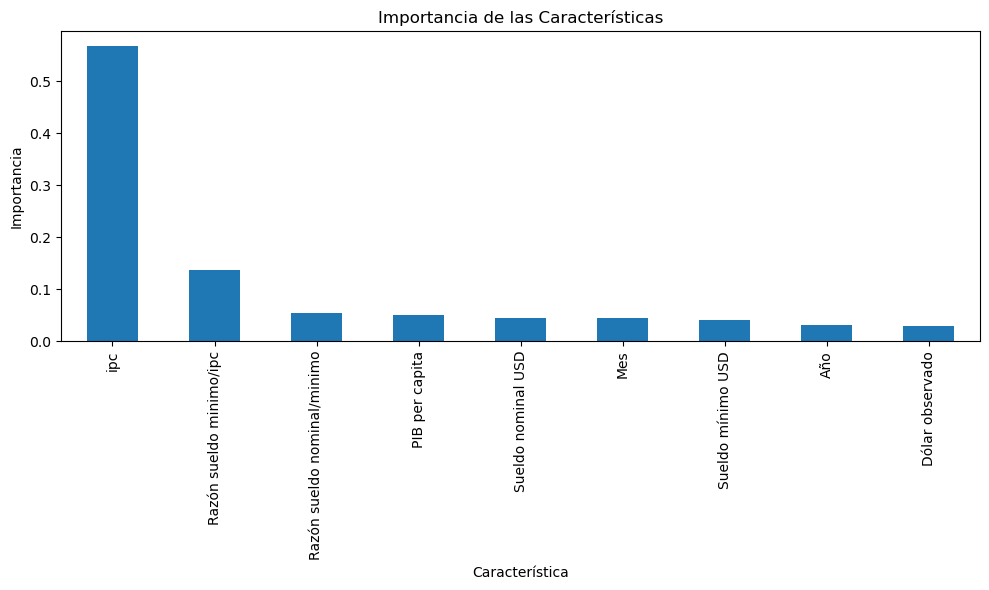

In [508]:
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Importancia de las características :")
print(feature_importances)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Importancia de las Características')
plt.ylabel('Importancia')
plt.xlabel('Característica')
plt.tight_layout()
plt.show()